In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pandas_datareader.data as pdr
import datetime 

In [2]:
sector = 'Automotive'
with open(f'./pre_processing_mp_mf/{sector}.json', 'r') as f:
    json_object = json.load(f)
trade_summary = [[[pd.DataFrame(json_object[i][j][k]) for k in range(len(json_object[0][0]))] for j in range(len(json_object[0]))] for i in range(len(json_object))]
tickers = np.zeros(len(trade_summary[0][0])).tolist()

In [3]:
range_mp,range_mf = len(trade_summary[0]),len(trade_summary)
profit = np.zeros((range_mf,range_mp))
success = np.zeros((range_mf,range_mp))
tot_trades = np.zeros((range_mf,range_mp))
for i in range(profit.shape[0]):
    for j in range(profit.shape[1]):
        tot_trades_temp = 0 # for a given (mp,mf) pair
        for k in range(len(tickers)):
            curr_profit_summary = (trade_summary[i][j][k]['SellPrice']-trade_summary[i][j][k]['BuyPrice'])*trade_summary[i][j][k]['Lots']
            
            if len(curr_profit_summary)>=1 : 
                if curr_profit_summary[-1:].isnull().values.any(): 
                    curr_profit_summary = curr_profit_summary[:-1]
                    trade_summary[i][j][k] = trade_summary[i][j][k][:-1]
                    # print('NaN encountered')
                success[i,j] += len(curr_profit_summary[curr_profit_summary>trade_summary[i][j][k]['BuyPrice']*trade_summary[i][j][k]['Lots']/100]) #*100/len(curr_profit_summary)            
                tot_trades_temp += len(curr_profit_summary)
            profit[i,j] += np.sum(curr_profit_summary)
        tot_trades[i,j] = tot_trades_temp

d:\Programming\Python\Time_data_prediction\fin-env\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


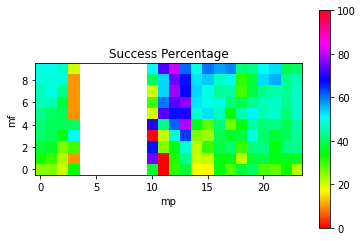

In [4]:
success_percent = (success/tot_trades)*100
success_percent_list = success_percent.tolist()
# x = [i for i in range(1,range_mp+1)]
# y = [i for i in range(1,range_mf+1)]

fig, ax = plt.subplots(1,1)
img = ax.imshow(success_percent_list,interpolation='none',origin='lower',cmap=plt.cm.hsv) # jet or viridis 
ax.set(xlabel='mp',ylabel='mf',title='Success Percentage')
fig.colorbar(img);

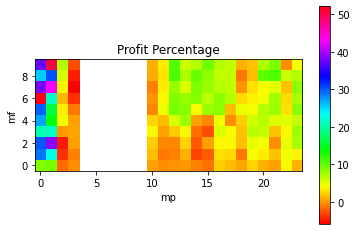

In [5]:
profit[profit==0] = np.nan
profit_list = (profit/1e4).tolist()
fig, ax = plt.subplots(1,1)
img = ax.imshow(profit_list,interpolation='none',origin='lower',cmap=plt.cm.hsv)
ax.set(xlabel='mp',ylabel='mf',title='Profit Percentage')
fig.colorbar(img);

### Hotspot
1. Prediction accuracy > 53% at that location.
2. Avg predition score of all 9 surrounding cells > 53%.  

We define a trading hotspot as a particular pairing of $(m_p,m_f)$ integers such that  
1. $S(m_p,m_f)>0.53$, percentage of successful trades for a particular pair should be greater than 0.53.
2. $1/9\sum_{j=-1}^1\sum_{k=-1}^1 S_{m_p+k,m_f+j}>0.53$, basically average of the 9 surrounding cells should be greater than 0.53.

In [6]:
## Identify the trading hotspot
potential_hotspots = []
for i in range(1,success_percent.shape[0]-1):
    for j in range(1,success_percent.shape[1]-1):
        if success_percent[i,j]>=53 and np.mean(success_percent[i-1:i+2,j-1:j+2])>=53:
            potential_hotspots.append([i,j])

After trading hotspot is identified (if it is present), we can test the algorithm on the remaining data using the values of the trading hotspot.  

Else this particular sector is not feasible to trade in. Need to look for another sector for this strategy to work.

In [7]:
potential_hotspots

[[4, 12],
 [4, 13],
 [5, 11],
 [5, 12],
 [5, 13],
 [6, 12],
 [6, 13],
 [7, 11],
 [7, 12],
 [7, 13],
 [7, 14],
 [8, 11],
 [8, 12],
 [8, 13]]

In [8]:
max = 0
hotspot = []
for i in range(len(potential_hotspots)):
    if success_percent[potential_hotspots[i][0],potential_hotspots[i][1]]>=max: 
        max = success_percent[potential_hotspots[i][0],potential_hotspots[i][1]]
        hotspot = potential_hotspots[i]
hotspot = [hotspot[0]+1,hotspot[1]+1] # Chaning from indices to actual values

In [9]:
hotspot

[5, 14]

In [10]:
success_percent[hotspot[0]-1:hotspot[0]+2,hotspot[1]-1:hotspot[1]+2]

array([[80.        , 35.8490566 , 28.07017544],
       [69.23076923, 47.27272727, 52.45901639],
       [76.92307692, 52.63157895, 49.20634921]])

# Test the Hotspot

In [11]:
# Input
start_date = datetime.datetime(2016,1,1)
end_date = datetime.datetime.today()

nstocks = 10
sector_data = pd.read_csv(f'./sector_data/{sector}.csv',index_col=0)
tickers = list(sector_data.nlargest(len(tickers),'MktCap')['Ticker'])

data = pdr.get_data_yahoo(tickers,start_date,end_date)
data = data.dropna()

In [12]:
temp_list = []
for i in tickers:
    temp_list.append(np.array([data['Adj Close'][i]]).T)
X = np.block([temp_list]).T
## Assign train data
X_train = X[:,:int(X.shape[1]/3)]
X_test = X[:,int(X.shape[1]/3):]
X_train.shape

(10, 551)

In [13]:
def DMD(X,r,dt,mf):
    '''
    Inputs:
        X = numpy.ndarray: Historical time series data with time along the columns and current time being the last column
        r = scalar: Number of main modes to consider
        dt = scaler: time step between each column
        mf = scalar: Number of future time steps you want to predict
    Outputs:
        X_DMD = mf+1 columns of predicted time series data with first column being the current time step
    '''
    X1,X2 = X[:,:-1],X[:,1:] # Last column of X is current price of the day close to closing
    U,s,Vh = np.linalg.svd(X1,full_matrices=False)
    r = min(r,np.shape(U)[1])
    Ur,Sr,Vr = U[:,:r],np.diag(s[:r]),Vh[:r,:].T
    A_T = Ur.T@X2@Vr@np.linalg.inv(Sr)
    d,Wr = np.linalg.eig(A_T)
    Phi = X2@Vr@np.linalg.inv(Sr)@Wr
    Lambda = np.diag(d)
    Omega = np.log(Lambda)/dt
    b = np.linalg.pinv(Phi)@X[:,-1:]
    
    t = np.arange(0,(mf+1)*dt,dt)
    t = t.reshape((t.shape[0],1,1))
    time_dynamics = np.exp(t*Omega)@b
    X_DMD = (Phi@time_dynamics).T.reshape((Phi.shape[0],t.shape[0]))
    return X_DMD
    

In [14]:
def backtest(mf,mp,X_inp):
    ## Initialize variables
    #### When did we buy and at what price, when did we sell and at what price
    bank_balance = 1000000
    #### Queues to store at what index we bought that stock
    q = [np.array([]) for i in range(len(tickers))]
    #### trade summary for every stock 
    trade_summary = [pd.DataFrame(columns=['BuyDate_index','BuyPrice','SellDate_index','SellPrice','Lots']) for i in range(len(tickers))] # For 1 stock, make similar structure for other stocks as well
    #### Bank balance is distributed equally among stocks
    balance_per_stock = np.ones((len(tickers),1))*bank_balance/len(tickers)

    ## Begin for loop from max(mp) to train-max(mf)
    for i in range(24,X_inp.shape[1]-10):
        #### If bought at i-mf (check queue and remove if present) then sell
        for j in range(len(tickers)):
            if q[j].shape[0]!=0: # if queue is not empty
                if q[j][-1]==i-mf: # if last element is mf days before current then sell
                    ###### Sell means to pop queue, append P&L along with the iteration number and increase the bank balance again taking into account the P&L and transaction/brokerage cost (8 per trade)
                    q[j] = q[j][:-1]
                    ######## Update trade summary
                    trade_summary[j].iloc[len(trade_summary[j].index)-1][2:4] = [i,X_inp[j,i]]
                    ######## Update balance per stock
                    balance_per_stock[j] += X_inp[j,i]*trade_summary[j].iloc[len(trade_summary[j].index)-1][-1] # Include transaction costs
                
        #### If balance is there and DMD(...)[:,-1:] i.e. predicted price is greater than 1% then buy else do nothing
        dmd = DMD(X_inp[:,i-mp:i+1],5,1,mf)[:,-1:]
        for j in range(len(tickers)):
            if balance_per_stock[j]>=X_inp[j,i] and (dmd[j,0]-X_inp[j,i])/X_inp[j,i]>0.01:
                ## Buy 
                lots = int(balance_per_stock[j]/X_inp[j,i])
                #### Buy means append queue of possesions
                q[j] = np.append(q[j],i)
                #### Update trade summary
                trade_summary[j].loc[len(trade_summary[j].index)] = [i,X_inp[j,i],np.nan,np.nan,lots]
                #### Update (subtract) balance per stock
                balance_per_stock[j] -= lots*X_inp[j,i]

    return trade_summary
        ###### Buy means Bank balance is reduced queue is appended with the iteration number

In [15]:
test_trade_summary = backtest(hotspot[0],hotspot[1],X_test)

d:\Programming\Python\Time_data_prediction\fin-env\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
d:\Programming\Python\Time_data_prediction\fin-env\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
d:\Programming\Python\Time_data_prediction\fin-env\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
d:\Programming\Python\Time_data_prediction\fin-env\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


In [16]:
profit_test = 0
success_test = 0
tot_trades_test = 0 # for a given (mp,mf) pair
for k in range(len(tickers)):
    curr_profit_summary = (test_trade_summary[k]['SellPrice']-test_trade_summary[k]['BuyPrice'])*test_trade_summary[k]['Lots']
    
    if len(curr_profit_summary)>=1 : 
        if curr_profit_summary[-1:].isnull().values.any(): 
            curr_profit_summary = curr_profit_summary[:-1]
            test_trade_summary[k] = test_trade_summary[k][:-1]
            # print('NaN encountered')
        success_test += len(curr_profit_summary[curr_profit_summary>test_trade_summary[k]['BuyPrice']*test_trade_summary[k]['Lots']/100]) #*100/len(curr_profit_summary)            
        tot_trades_test += len(curr_profit_summary)
    profit_test += np.sum(curr_profit_summary)
print('Profit', profit_test)
print('Success Trades',success_test,'; Total trades',tot_trades_test)
print('Success Percentage',success_test/tot_trades_test*100)

Profit 149294.7996673584
Success Trades 25 ; Total trades 41
Success Percentage 60.97560975609756
